In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [181]:
def clean_data(x, y=None, scaler=None):
    x = x.drop('patient_id', axis=1)
    x = pd.get_dummies(x)
    x = x.drop('thal_reversible_defect', axis=1)
    if y is not None:
        y = y['heart_disease_present']
    if scaler is None:
        scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    return scaler, x, y

In [182]:
x = pd.read_csv('../Data/train_values.csv')
y = pd.read_csv('../Data/train_labels.csv')
x_test = pd.read_csv('../Data/test_values.csv')
patient_id_test = x_test['patient_id']
scaler, x, y = clean_data(x, y)
_, x_test, _ = clean_data(x_test, None, scaler)

In [183]:
x[0]

array([-0.89124111, -0.19519463, -1.23477477, -0.71840267, -0.4382385 ,
        0.95384966,  1.11826909, -0.90320689,  0.67202151, -1.05396422,
        0.93248505, -0.68074565, -0.21566555,  0.91473203])

In [184]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Logistic Regression

In [185]:
steps = [('scaler', StandardScaler()), ('classifier', LogisticRegression())]
pipeline = Pipeline(steps)
parameters = {'classifier__threshold':np.arange(0, 1)}

In [186]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [187]:
y_pred_prob = pipeline.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

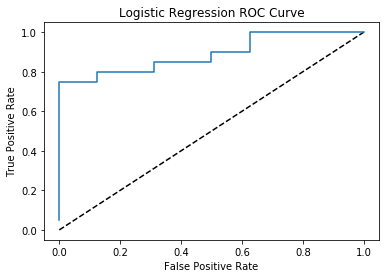

In [188]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [189]:
y_pred_prob = pipeline.predict_proba(x_val)[:,1]
roc_auc_score(y_val, y_pred_prob)

0.890625

In [190]:
cv_scores = cross_val_score(pipeline, x, y, cv=5, scoring='roc_auc')
cv_scores

array([0.834375, 0.903125, 0.9875  , 0.809375, 0.859375])

## K-Neighbors

In [191]:
steps = [('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = {'classifier__n_neighbors':np.arange(1, 50)}

In [192]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [193]:
y_pred = cv.predict(x_val)

In [194]:
print(cv.best_params_)

{'classifier__n_neighbors': 16}


In [195]:
print(cv.score(x_val, y_val))

0.8055555555555556


In [196]:
print(cv.score(x_train, y_train))

0.8402777777777778


In [197]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          0       0.70      1.00      0.82        16
          1       1.00      0.65      0.79        20

avg / total       0.86      0.81      0.80        36



## Deep Learning

In [198]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [199]:
n_cols = x.shape[1]
# target = to_categorical(y)
target = y
early_stopping_monitor = EarlyStopping(patience=20)
model = Sequential()
model.add(Dense(n_cols*2, activation='relu', input_shape=(n_cols,), activity_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_cols, activation='relu', input_shape=(n_cols,), activity_regularizer=regularizers.l2(0.0001)))
model.add(Dense(n_cols//2, activation='relu', input_shape=(n_cols,), activity_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1, activation='sigmoid'))
optim = optimizers.SGD(lr=0.008)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
# model.summary()

Train on 144 samples, validate on 36 samples
Epoch 1/5000
144/144 [==============================] - 0s 2ms/sample - loss: 0.2872 - accuracy: 0.4444 - val_loss: 0.2622 - val_accuracy: 0.5833
Epoch 2/5000
144/144 [==============================] - 0s 63us/sample - loss: 0.2832 - accuracy: 0.4514 - val_loss: 0.2601 - val_accuracy: 0.5833
Epoch 3/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.2793 - accuracy: 0.4583 - val_loss: 0.2582 - val_accuracy: 0.5833
Epoch 4/5000
144/144 [==============================] - 0s 97us/sample - loss: 0.2757 - accuracy: 0.4583 - val_loss: 0.2562 - val_accuracy: 0.6111
Epoch 5/5000
144/144 [==============================] - 0s 97us/sample - loss: 0.2722 - accuracy: 0.4583 - val_loss: 0.2545 - val_accuracy: 0.6111
Epoch 6/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.2690 - accuracy: 0.4653 - val_loss: 0.2526 - val_accuracy: 0.6111
Epoch 7/5000
144/144 [==============================] - 0s 90us/sample - l

144/144 [==============================] - 0s 69us/sample - loss: 0.1862 - accuracy: 0.8194 - val_loss: 0.2094 - val_accuracy: 0.6944
Epoch 57/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.1850 - accuracy: 0.8194 - val_loss: 0.2087 - val_accuracy: 0.6944
Epoch 58/5000
144/144 [==============================] - 0s 63us/sample - loss: 0.1838 - accuracy: 0.8194 - val_loss: 0.2081 - val_accuracy: 0.6944
Epoch 59/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.1827 - accuracy: 0.8194 - val_loss: 0.2075 - val_accuracy: 0.6944
Epoch 60/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.1816 - accuracy: 0.8194 - val_loss: 0.2069 - val_accuracy: 0.6944
Epoch 61/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.1805 - accuracy: 0.8264 - val_loss: 0.2063 - val_accuracy: 0.6944
Epoch 62/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.1794 - accuracy: 0.8264 - val_loss: 0.2057 -

144/144 [==============================] - 0s 83us/sample - loss: 0.1376 - accuracy: 0.8542 - val_loss: 0.1820 - val_accuracy: 0.7778
Epoch 112/5000
144/144 [==============================] - 0s 69us/sample - loss: 0.1370 - accuracy: 0.8542 - val_loss: 0.1816 - val_accuracy: 0.7778
Epoch 113/5000
144/144 [==============================] - 0s 62us/sample - loss: 0.1363 - accuracy: 0.8542 - val_loss: 0.1813 - val_accuracy: 0.7778
Epoch 114/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.1357 - accuracy: 0.8611 - val_loss: 0.1810 - val_accuracy: 0.7778
Epoch 115/5000
144/144 [==============================] - 0s 69us/sample - loss: 0.1352 - accuracy: 0.8611 - val_loss: 0.1805 - val_accuracy: 0.7778
Epoch 116/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.1345 - accuracy: 0.8681 - val_loss: 0.1802 - val_accuracy: 0.7778
Epoch 117/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.1339 - accuracy: 0.8681 - val_loss: 0.

144/144 [==============================] - 0s 90us/sample - loss: 0.1115 - accuracy: 0.8681 - val_loss: 0.1684 - val_accuracy: 0.8611
Epoch 167/5000
144/144 [==============================] - 0s 62us/sample - loss: 0.1111 - accuracy: 0.8681 - val_loss: 0.1682 - val_accuracy: 0.8611
Epoch 168/5000
144/144 [==============================] - 0s 76us/sample - loss: 0.1108 - accuracy: 0.8681 - val_loss: 0.1681 - val_accuracy: 0.8611
Epoch 169/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.1105 - accuracy: 0.8681 - val_loss: 0.1680 - val_accuracy: 0.8611
Epoch 170/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.1102 - accuracy: 0.8681 - val_loss: 0.1678 - val_accuracy: 0.8611
Epoch 171/5000
144/144 [==============================] - 0s 76us/sample - loss: 0.1098 - accuracy: 0.8681 - val_loss: 0.1677 - val_accuracy: 0.8611
Epoch 172/5000
144/144 [==============================] - 0s 76us/sample - loss: 0.1095 - accuracy: 0.8681 - val_loss: 0.

Epoch 221/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.0971 - accuracy: 0.8889 - val_loss: 0.1638 - val_accuracy: 0.8333
Epoch 222/5000
144/144 [==============================] - 0s 70us/sample - loss: 0.0969 - accuracy: 0.8889 - val_loss: 0.1637 - val_accuracy: 0.8333
Epoch 223/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0967 - accuracy: 0.8889 - val_loss: 0.1637 - val_accuracy: 0.8333
Epoch 224/5000
144/144 [==============================] - 0s 76us/sample - loss: 0.0965 - accuracy: 0.8889 - val_loss: 0.1638 - val_accuracy: 0.8333
Epoch 225/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0963 - accuracy: 0.8958 - val_loss: 0.1636 - val_accuracy: 0.8333
Epoch 226/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.0961 - accuracy: 0.8958 - val_loss: 0.1636 - val_accuracy: 0.8333
Epoch 227/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.0959 - accuracy: 0.8889

Epoch 276/5000
144/144 [==============================] - 0s 69us/sample - loss: 0.0878 - accuracy: 0.9097 - val_loss: 0.1622 - val_accuracy: 0.8056
Epoch 277/5000
144/144 [==============================] - 0s 118us/sample - loss: 0.0877 - accuracy: 0.9097 - val_loss: 0.1622 - val_accuracy: 0.8056
Epoch 278/5000
144/144 [==============================] - 0s 97us/sample - loss: 0.0875 - accuracy: 0.9097 - val_loss: 0.1622 - val_accuracy: 0.8056
Epoch 279/5000
144/144 [==============================] - 0s 76us/sample - loss: 0.0874 - accuracy: 0.9097 - val_loss: 0.1623 - val_accuracy: 0.8056
Epoch 280/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0872 - accuracy: 0.9097 - val_loss: 0.1623 - val_accuracy: 0.8056
Epoch 281/5000
144/144 [==============================] - 0s 90us/sample - loss: 0.0871 - accuracy: 0.9097 - val_loss: 0.1623 - val_accuracy: 0.8056
Epoch 282/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0870 - accuracy: 0.909

144/144 [==============================] - 0s 83us/sample - loss: 0.0811 - accuracy: 0.9097 - val_loss: 0.1620 - val_accuracy: 0.8056
Epoch 331/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0810 - accuracy: 0.9097 - val_loss: 0.1621 - val_accuracy: 0.8056
Epoch 332/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0808 - accuracy: 0.9097 - val_loss: 0.1621 - val_accuracy: 0.8056
Epoch 333/5000
144/144 [==============================] - 0s 76us/sample - loss: 0.0808 - accuracy: 0.9097 - val_loss: 0.1622 - val_accuracy: 0.8056
Epoch 334/5000
144/144 [==============================] - 0s 66us/sample - loss: 0.0806 - accuracy: 0.9097 - val_loss: 0.1622 - val_accuracy: 0.8056
Epoch 335/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0806 - accuracy: 0.9097 - val_loss: 0.1623 - val_accuracy: 0.8056
Epoch 336/5000
144/144 [==============================] - 0s 83us/sample - loss: 0.0804 - accuracy: 0.9097 - val_loss: 0.

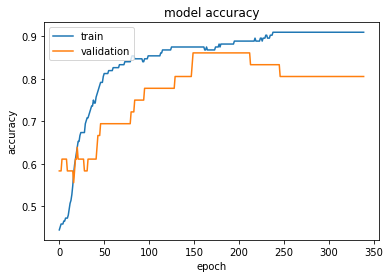

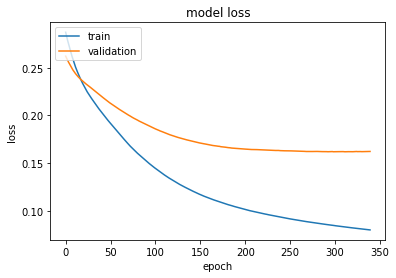

In [200]:
history = model.fit(x, target, validation_split=0.2, epochs=5000, callbacks = [early_stopping_monitor])
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [201]:
predictions = model.predict(x_test)
predictions = predictions.reshape(90)
predictions

array([0.0739069 , 0.1129162 , 0.9293492 , 0.12969944, 0.88285875,
       0.09528941, 0.1790855 , 0.94639003, 0.19344065, 0.07774431,
       0.39480186, 0.6177814 , 0.6535082 , 0.95687985, 0.17471659,
       0.05548561, 0.06742007, 0.15326524, 0.9305277 , 0.06363118,
       0.88096476, 0.17608109, 0.15411258, 0.04565176, 0.4408211 ,
       0.8850077 , 0.8226378 , 0.26284355, 0.37063512, 0.09574828,
       0.69296265, 0.43299904, 0.80172336, 0.29660034, 0.07761285,
       0.08012444, 0.37689954, 0.31045362, 0.25227082, 0.0903241 ,
       0.85076064, 0.05260345, 0.9420177 , 0.02213624, 0.93786037,
       0.09147832, 0.07965139, 0.10158882, 0.2002461 , 0.89538836,
       0.4640685 , 0.09492117, 0.98066413, 0.18015388, 0.2031394 ,
       0.12149903, 0.90040183, 0.17272013, 0.45464116, 0.51155823,
       0.11032605, 0.951372  , 0.15435442, 0.9093338 , 0.14414331,
       0.75887716, 0.4817601 , 0.5689907 , 0.88644284, 0.7813826 ,
       0.17102814, 0.95056015, 0.9256402 , 0.96543753, 0.93680

In [203]:
def save_result(predictions, file_name='results.csv'):
    results = pd.DataFrame()
    results['patient_id'] = patient_id_test
    results['heart_disease_present'] = predictions
    results.to_csv('results.csv', index=False)
    return results

In [204]:
results = save_result(predictions)
results.head()

,patient_id,heart_disease_present
0,olalu7,0.073907
1,z9n6mx,0.112916
2,5k4413,0.929349
3,mrg7q5,0.129699
4,uki4do,0.882859
